# Weighted metrics

In [ ]:
y_true = yosh.obs['Original_annotation']
y_pred = y_true.copy()

In [275]:
project = neptune.init_project(
            project="becavin-lab/benchmark",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
        mode="read-only",
            )# For checkpoint

runs_table_df = project.fetch_runs_table().to_pandas()
project.stop()

https://app.neptune.ai/becavin-lab/benchmark/
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/becavin-lab/benchmark/metadata


In [ ]:
run = neptune.init_run(project="becavin-lab/benchmark",
                    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
                 with_id= 'BEN-1')
run[f"parameters/split_random_seed"] = 0
run.stop()

In [427]:
def make_weight(y_true):
    '''
    return a weight for each element of y_true corresponding to the number of elements of its class.
    Balanced metrics should use 1/weights
    '''
    y_true_s = pd.Series(y_true)
    ct_weights = y_true_s.value_counts()
    weights = np.array(y_true_s.replace(ct_weights))
    return weights
    
def balanced_f1_score(y_true,y_pred):
    weights = make_weight(y_true)
    return f1_score(y_true, y_pred, sample_weight=1/weights)

def balanced_matthews_corrcoef(y_true,y_pred):
    weights = make_weight(y_true)
    return matthews_corrcoef(y_true, y_pred, sample_weight=1/weights)

def balanced_cohen_kappa_score(y_true,y_pred):
    weights = make_weight(y_true)
    return cohen_kappa_score(y_true, y_pred, sample_weight=1/weights)

In [281]:
runs_table_df = load_run_df()

https://app.neptune.ai/becavin-lab/benchmark/
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/becavin-lab/benchmark/metadata


In [306]:
run.stop()

In [ ]:
from tqdm.notebook import trange, tqdm
import warnings

warnings.filterwarnings('ignore')

def nan_to_0(val):
    if np.isnan(val) or pd.isna(val) or type(val) == type(None) :
        return 0.0
    else :
        return val

for ID, dataset_name, class_key in tqdm(zip(runs_table_df['sys_id'],runs_table_df['dataset_name'],runs_table_df['class_key'])):
    if not pd.isna(dataset_name) and ID != 'BEN-1':
        run = neptune.init_run(project="becavin-lab/benchmark",
                    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
                 with_id= ID)
        
        y_full = load_pred(ID)
        y_true_full = y['true']
        split_full = y['split']
        y_pred_full = y['pred']
        print(ID,dataset_name,class_key)
        
        ct_prop = y_true_full.value_counts() / y_true_full.value_counts().sum()

        sizes = {'xxsmall' : list(ct_prop[ct_prop < 0.001].index), 
                 'small': list(ct_prop[(ct_prop >= 0.001) & (ct_prop < 0.01)].index) ,
                 'medium': list(ct_prop[(ct_prop >= 0.01) & (ct_prop < 0.1)].index),
                 'large': list(ct_prop[ct_prop >= 0.1].index)}
        for group in ['train', 'test', 'val', 'full']:
            # print(group)
            if group != 'full':
                y_true = y_true_full.loc[split_full == group]
                y_pred = y_pred_full.loc[split_full == group]
            else :
                y_true = y_true_full
                y_pred = y_pred_full
            for s in sizes : 
                idx_s = np.isin(y_true, sizes[s]) # Boolean array, no issue to index y_pred
                y_true_sub = y_true[idx_s]
                y_pred_sub = y_pred[idx_s]
                # print(s)
                for metric in pred_metrics_list: 
                    # print(metric)
                    run[f"evaluation/{group}/{s}/{metric}"] = nan_to_0(pred_metrics_list[metric](y_true_sub, y_pred_sub))
                    # print(nan_to_0(pred_metrics_list[metric](y_true_sub, y_pred_sub)))
                
                for metric in pred_metrics_list_balanced:
                    # print(metric)
                    # print(nan_to_0(pred_metrics_list_balanced[metric](y_true_sub, y_pred_sub)))
                    run[f"evaluation/{group}/{s}/{metric}"] = nan_to_0(pred_metrics_list_balanced[metric](y_true_sub, y_pred_sub))
        run.stop()

In [ ]:
ct_prop = pd.Series(y_true).value_counts() / pd.Series(y_true).value_counts().sum()

sizes = {'xxsmall' : list(ct_prop[ct_prop < 0.001].index), 
         'small': list(ct_prop[(ct_prop >= 0.001) & (ct_prop < 0.01)].index) ,
         'medium': list(ct_prop[(ct_prop >= 0.01) & (ct_prop < 0.1)].index),
         'large': list(ct_prop[ct_prop >= 0.1].index)}
for s in sizes : 
    idx_s = np.isin(y_true, sizes[s])
    y_true_sub = y_true[idx_s]
    y_pred_sub = y_pred[idx_s]
    print(s)
    for metric in pred_metrics_list: 
        print(metric)
        print(pred_metrics_list[metric](y_true_sub, y_pred_sub))
    
    for metric in pred_metrics_list_balanced:
        print(metric)
        print(pred_metrics_list_balanced[metric](y_true_sub, y_pred_sub))


In [ ]:
ct_prop = y_true.value_counts() / y_true.value_counts().sum()

sizes = {'xxsmall' : ct_prop[ct_prop < 0.001].index, 
         'small': ct_prop[(ct_prop >= 0.001) & (ct_prop < 0.01)].index ,
         'medium': ct_prop[(ct_prop >= 0.01) & (ct_prop < 0.1)].index,
         'large': ct_prop[ct_prop >= 0.1].index}

In [ ]:
y_true_sub = y_true[y_true.isin(sizes['xxsmall'])]
y_pred_sub = y_pred[y_true_sub.index]

In [ ]:
for metric in pred_metrics_list: 
    print(metric)
    print(pred_metrics_list[metric](y_true_sub, y_pred_sub))

for metric in pred_metrics_list_balanced:
    print(metric)
    print(pred_metrics_list_balanced[metric](y_true_sub, y_pred_sub))


# Diff with 2nd

In [85]:
ds_names= [i for v in diff_dict for i in diff_dict[v]]
t1_acc_res_avg = pd.concat(t1_acc_res_avg, axis=  1)
t1_acc_res_med = pd.concat(t1_acc_res_med, axis=  1)
t1_acc_res_avg.columns = ds_names
t1_acc_res_med.columns = ds_names

In [88]:
ds_name = 'scPermut'
ds_name = 'scPermut - default'

In [98]:
opt_avg = t1_acc_res_avg.loc['scPermut',:] - t1_acc_res_avg.loc[~t1_acc_res_avg.index.isin(['scPermut', 'scPermut - default']),:].max()
default_avg = t1_acc_res_avg.loc['scPermut - default',:] - t1_acc_res_avg.loc[~t1_acc_res_avg.index.isin(['scPermut', 'scPermut - default']),:].max()
opt_avg_med = t1_acc_res_med.loc['scPermut',:] - t1_acc_res_med.loc[~t1_acc_res_med.index.isin(['scPermut', 'scPermut - default']),:].max()
default_avg_med = t1_acc_res_med.loc['scPermut - default',:] - t1_acc_res_med.loc[~t1_acc_res_med.index.isin(['scPermut', 'scPermut - default']),:].max()
res = pd.concat([opt_avg,default_avg,opt_avg_med,default_avg_med], axis = 1)
res.columns = ['opt_avg', 'default_avg', 'opt_avg_med', 'default_avg_med']

<Axes: >

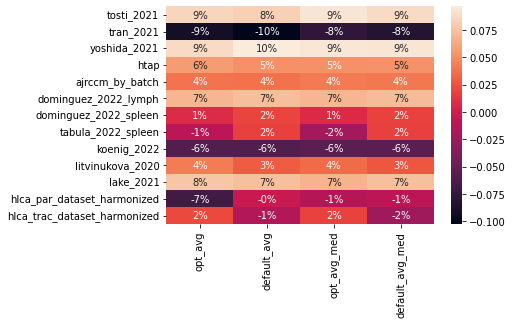

In [105]:
sns.heatmap(res, annot = True, fmt = ".0%")

# yoshida test

In [ ]:
test = pd.read_csv(working_dir + 'analysis_notebooks/benchmark_metrics/yoshida_2021/task_1_test.csv', index_col ='Id')
f =  lambda x : x.replace('evaluation/', '').replace('parameters/', '').replace('/', '_')

test.columns = np.array(list(map(f, test.columns)))


In [ ]:
test

### Simple but efficient dotplots

In [ ]:
sns.boxplot(x='model',y ='val_mcc',hue = 'test_fold_nb', data = test)

In [ ]:
sns.boxplot(x='model',y ='test_mcc',hue = 'test_fold_nb', data = test)

In [ ]:
sns.boxplot(x='model',y ='val_balanced_acc',hue = 'val_fold_nb', data = test)

In [ ]:
sns.boxplot(x='model',y ='test_balanced_acc',hue = 'test_fold_nb', data = test)

In [ ]:
yosh = load_dataset('yoshida_2021', dataset_dir = working_dir + 'data')

In [ ]:
def load_confusion_matrix(neptune_id,train_split= 'val', working_dir = None):
    if working_dir :
        save_dir = working_dir + 'experiment_script/results/' + str(neptune_run_id) + '/'
    else :
        save_dir = './experiment_script/results/' + str(neptune_id) + '/'
    return pd.read_csv(save_dir + f'confusion_matrix_{train_split}.csv', index_col =0)

def load_pred(neptune_id, working_dir = None):
    if working_dir :
        save_dir = working_dir + 'experiment_script/results/' + str(neptune_run_id) + '/'
    else :
        save_dir = './experiment_script/results/' + str(neptune_id) + '/'
    return pd.read_csv(save_dir + f'predictions_full.csv', index_col =0)


It's just my way of computing full conf matrix that is innacurate ?

### Plotting confusion matrix

In [ ]:
for mod, cm_to_plot in conf.items():
    size = len(cm_to_plot.index)
    f, ax = plt.subplots(figsize=(size/2,size/2))
    sns.heatmap(cm_to_plot, annot=True, ax=ax,fmt ='.2g', vmin = 0)
    show_mask = np.asarray(cm_to_plot>0.01)
    for text, show_annot in zip(ax.texts, (element for row in show_mask for element in row)):
        text.set_visible(show_annot)
    ax.set_title(mod)

### Explanation of varying accuracy

In [ ]:
adatas = {name:load_dataset(name, working_dir+ 'data') for name in dataset_names}

In [ ]:
batch_key_dict = {'htap':'donor', 
'yoshida_2021':'batch',
'hlca_trac_dataset_harmonized':'dataset',
'lake_2021':'batch',
'dominguez_2022_spleen':'batch',
'ajrccm_by_batch':'donor',
'tosti_2021':'batch',
'tran_2021':'batch', 
'litvinukova_2020':'batch', 
'hlca_par_dataset_harmonized':'dataset', 
'dominguez_2022_lymph':'batch', 
'tabula_2022_spleen':'batch',
                 'koenig_2022': 'batch'}

In [ ]:

def get_sizes(adata, ct_key):
    ct_prop = adata.obs[ct_key].value_counts()/ adata.n_obs
    sizes = {'xxsmall' : list(ct_prop[ct_prop < 0.001].index), 
            'small': list(ct_prop[(ct_prop >= 0.001) & (ct_prop < 0.01)].index),
            'medium': list(ct_prop[(ct_prop >= 0.01) & (ct_prop < 0.1)].index),
            'large': list(ct_prop[ct_prop >= 0.1].index)}
    return sizes

In [ ]:
runs_table_df = load_run_df()
runs_table_df.loc[(runs_table_df['model'] == 'scPermut') & (runs_table_df['use_hvg'] == 3000),'model'] = 'scPermut_default'


In [ ]:
task_1 = runs_table_df.query("task == 'task_1'").query('deprecated_status == False').query("model == 'scPermut_default'").query("training_scheme == 'training_scheme_8'")#[['dataset_name', 'test_balanced_acc']]


In [ ]:
task_1.columns

In [ ]:
for model in tqdm(aestetic_model_name) : 
    if model in ['scPermut_default', 'scPermut']:
        task_1 = runs_table_df.query("task == 'task_1'").query('deprecated_status == False').query(f"model == '{model}'").query("training_scheme == 'training_scheme_8'")
    else:
        task_1 = runs_table_df.query("task == 'task_1'").query('deprecated_status == False').query(f"model == '{model}'")
    print(task_1['dataset_name'].value_counts())

In [ ]:
# task_1 = runs_table_df.query("task == 'task_1'").query('deprecated_status == False').query("model == 'scPermut_default'").query("training_scheme == 'training_scheme_8'")#[['dataset_name', 'test_balanced_acc']]
from tqdm.notebook import tqdm
for model in tqdm(aestetic_model_name) : 
    if model in ['scPermut_default', 'scPermut']:
        task_1 = runs_table_df.query("task == 'task_1'").query('deprecated_status == False').query(f"model == '{model}'").query("training_scheme == 'training_scheme_8'")
    else:
        task_1 = runs_table_df.query("task == 'task_1'").query('deprecated_status == False').query(f"model == '{model}'")
    print(task_1[model].value_counts)
    plt.figure()
    g=sns.pairplot(task_1[['full_batch_mixing_entropy', 'train_balanced_acc','test_balanced_acc']])
    g.fig.suptitle(model, y=1.08) # y= some height>1

In [ ]:
complexity_df = pd.read_csv(working_dir + 'experiment_script/benchmark/complexity_df.csv', index_col = 0)

In [ ]:
complexity_df.index = complexity_df.dataset

In [ ]:
n_batches = pd.Series({n:i.obs[batch_key_dict[n]].nunique() for n,i in adatas.items()})

In [ ]:
complexity_df['n_batches'] = n_batches

In [ ]:
for ds in complexity_df['dataset']:
    s = {'n_' + k: len(v) for k, v in get_sizes(adatas[ds], class_key_dict[ds]).items()}
    for k, v in s.items():
        complexity_df.loc[ds, k] = v

In [ ]:
complexity_df= complexity_df.reset_index()

In [ ]:
complexity_df.to_csv(working_dir + 'experiment_script/benchmark/complexity_df.csv')

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [ ]:
task_1 = runs_table_df.query("task == 'task_1'").query('deprecated_status == False').query("model == 'scPermut_default'").query("training_scheme == 'training_scheme_8'")[['dataset_name', 'test_balanced_acc']]


In [ ]:
df = pd.merge(task_1, complexity_df, left_on = 'dataset_name', right_on = 'dataset')
sns.pairplot(df)

In [ ]:
feature_names = ['n_cells','complexity','n_celltypes', 'n_batches', 'n_xxsmall','n_small','n_medium','n_large']

for model in aestetic_model_name : 
    if model in ['scPermut_default', 'scPermut']:
        task_1 = runs_table_df.query("task == 'task_1'").query('deprecated_status == False').query(f"model == '{model}'").query("training_scheme == 'training_scheme_8'")[['dataset_name', 'test_balanced_acc']]
    else:
        task_1 = runs_table_df.query("task == 'task_1'").query('deprecated_status == False').query(f"model == '{model}'")[['dataset_name', 'test_balanced_acc']]

    df = pd.merge(task_1, complexity_df, left_on = 'dataset_name', right_on = 'dataset')
    
    best_score = 0
    df = df.dropna()
    if not df.empty:
        for L in range(len(feature_names) + 1):
            for subset in itertools.combinations(feature_names, L):
                if subset:
                    subset = list(subset)
                    lr = LinearRegression()
                
                    X = df[subset].values
                    Y = df['test_balanced_acc'].values
                    
                    lr.fit(X, Y)
                    score = lr.score(X, Y)
                    if score > best_score:
                        best_score = score
                        best_coeff = lr.coef_
                        best_features = subset
                    if len(subset) == 8:
                        full_score = score
                        full_coeff = lr.coef_
        plt.figure()
        sns.heatmap(np.abs(best_coeff.reshape(-1,1)), yticklabels = best_features, annot=True)
        plt.title(f'{model} R2 = {best_score}')

### Correlation between mean acc and dataset characteristics

In [ ]:
{n:i.n_obs for n,i in adatas.items()}

In [ ]:
class_key_dict = {'htap':'ann_finest_level', 
'yoshida_2021':'Original_annotation',
'hlca_trac_dataset_harmonized':'ann_finest_level',
'lake_2021':'Original_annotation',
'dominguez_2022_spleen':'Original_annotation',
'ajrccm_by_batch':'celltype',
'tosti_2021':'Original_annotation',
'tran_2021':'Original_annotation', 
'litvinukova_2020':'Original_annotation', 
'hlca_par_dataset_harmonized':'ann_finest_level', 
'dominguez_2022_lymph':'Original_annotation', 
'tabula_2022_spleen':'Original_annotation',
                 'koenig_2022': 'Original_annotation'}

In [ ]:
def dataset_complexity(adata, class_key, plot_corr= False):
    pdata = dc.get_pseudobulk(
    adata,
    sample_col=class_key,
    groups_col=class_key,
    mode='mean',
    min_cells=0,
    min_counts=0
)
    corr_matrix = pd.DataFrame(np.corrcoef(pdata.X), index = pdata.obs_names, columns = pdata.obs_names)
    np.fill_diagonal(corr_matrix.values, 0)
    if plot_corr:
        plt.figure(figsize = (20,15))
        sns.heatmap(corr_matrix, vmax = 1, vmin = 0)
    return corr_matrix

In [ ]:
comp_dict = {}
for name, ad in adatas.items():
    print(name)
    print(class_key_dict[name])
    corr = dataset_complexity(adatas[name], class_key_dict[name],plot_corr=False)
    comp_dict[name] = corr.max(axis=1).mean()

In [ ]:
complexity_df = pd.DataFrame({'dataset': adatas.keys(),'complexity': adatas.values()})

In [ ]:
complexity_df = pd.DataFrame({'dataset': comp_dict.keys(),'complexity': comp_dict.values()})

In [ ]:
complexity_df['n_cells'] = [ad.n_obs for ad in adatas.values()]
complexity_df['n_celltypes'] = [len(ad.obs[class_key_dict[name]].unique()) for name,ad in adatas.items()]

In [ ]:
complexity_df.sort_values('complexity').plot.bar(x= 'dataset', y = 'complexity', ylim= 0.7)
complexity_df.sort_values('complexity').plot.bar(x= 'dataset', y = 'n_cells', ylim= 0.7)
complexity_df.sort_values('complexity').plot.bar(x= 'dataset', y = 'n_celltypes', ylim= 0.7)


In [ ]:
complexity_df.to_csv(working_dir + 'experiment_script/benchmark/complexity_df.csv')

### scatterplot with error

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


def scatter_error(data, x, y, group, figsize = (7,5), ax = None, return_ax = False, show = True, title = None):
    '''
    scatter plots of the mean of the x and y fields by group. Additional bars are plotted representing the variances of x and y by group
    '''
    mean_data = data.groupby(group, as_index=False).agg({x: 'mean', y: 'mean'})
    variance_data = data.groupby(group, as_index=False).agg({x: 'std', y: 'std'})

    plt.figure(figsize = figsize)
    sns.scatterplot(x=x, y=y, data=mean_data, hue=group, s=100, legend="full", ax = ax)
    if ax : 
        for index, row in enumerate(mean_data.itertuples()):
            ax.errorbar(
                x=getattr(row,x),
                y=getattr(row,y),
                xerr=variance_data.iloc[index][x],
                yerr=variance_data.iloc[index][y],
                fmt='o'
            )
        ax.set_xlabel(x)
        ax.set_ylabel(y)
    else:
        for index, row in enumerate(mean_data.itertuples()):
            plt.errorbar(
                x=getattr(row,x),
                y=getattr(row,y),
                xerr=variance_data.iloc[index][x],
                yerr=variance_data.iloc[index][y],
                fmt='o'
            )
        plt.xlabel(x)
        plt.ylabel(y)
        plt.title(title)
    if show:
        plt.show()

    plt.close()
    if return_ax :

        return ax

### scatterplot with error on a metric list

In [ ]:
n_metrics = len(pred_metrics_list)

f, axes = plt.subplots(n_metrics,n_metrics, figsize = (20,20),constrained_layout=True)
i = 0
for r in range(n_metrics):
    for c in range(n_metrics):
        ax = axes[r,c]
        x = 'val_' + pred_metrics_list[c]
        y = 'val_' + pred_metrics_list[r]
        scatter_error(data=test, x = x, y = y, group = 'model', ax = ax, show = False)
        ax.get_legend().remove()

        if r !=0:
            ax.set_xlabel('')
        if r == 0:
            ax.xaxis.set_label_position('top') 
        if c!=0 :
            ax.set_ylabel('')
    

In [ ]:
def plot_scatter(data, group, metric_list_1, metric_list_2, train_split = 'val'):
    '''
    given to sets of metrics, plots the scatterplots with error bars....

    train_split : one of ['train','val','test','full']    
    '''
    if len(metric_list_1) == 1:
        metric_list_1 = [metric_list_1]
    if len(metric_list_2) == 1:
        metric_list_2 = [metric_list_2]
    n_metrics_1 = len(metric_list_1)
    n_metrics_2 = len(metric_list_2)
    f, axes = plt.subplots(n_metrics_1,n_metrics_2, figsize = (20,20),constrained_layout=True)
    i = 0
    for r in range(n_metrics_1):
        for c in range(n_metrics_2):
            ax = axes[r,c]
            x = train_split + '_' + metric_list_2[c]
            y = train_split + '_' + metric_list_1[r]
            scatter_error(data=data, x = x, y = y, group = group, ax = ax, show = False)
            ax.get_legend().remove()
    
            if r !=0:
                ax.set_xlabel('')
            if r == 0:
                ax.xaxis.set_label_position('top') 
            if c!=0 :
                ax.set_ylabel('')
        

In [ ]:
plot_scatter(test, 'model', pred_metrics_list, clustering_metrics_list +clustering_metrics_list, train_split= 'val')

### Anti correlation of bal acc and other metrics

In [ ]:
def metrics_correlation(data):
    float_metrics = data.select_dtypes(include='float')

    corr_matrix = pd.DataFrame(np.corrcoef(float_metrics, rowvar = False), index = float_metrics.columns, columns = float_metrics.columns)
    corr_matrix = corr_matrix.sort_values('test_AMI', ascending=False, axis = 0)
    corr_matrix = corr_matrix.sort_values('test_AMI', ascending=False, axis = 1)
    plt.figure(figsize = (20,15))
    sns.heatmap(corr_matrix, cmap = 'vlag', vmax = 1 ,vmin = -1)

In [ ]:
float_metrics = test.select_dtypes(include='float')

corr_matrix = pd.DataFrame(np.corrcoef(float_metrics, rowvar = False), index = float_metrics.columns, columns = float_metrics.columns)
corr_matrix = corr_matrix.sort_values('test_AMI', ascending=False, axis = 0)
corr_matrix = corr_matrix.sort_values('test_AMI', ascending=False, axis = 1)

In [ ]:
plt.figure(figsize = (20,15))
sns.heatmap(corr_matrix, cmap = 'vlag', vmax = 1 ,vmin = -1)

In [ ]:
# 

In [ ]:
run_id = pd.read_csv('/home/acollin/dca_permuted_workflow/sc-permut(1).csv')['Id']

In [ ]:
import time
time.sleep(5)

In [ ]:
import neptune

In [ ]:
run = neptune.init_run(project="becavin-lab/sc-permut",
                    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
                 with_id=  'SCPER-2335')

In [ ]:
run = neptune.init_run(project="becavin-lab/sc-permut",
                    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
                 with_id=  'SCPER-2335')
run.stop()

In [ ]:
for i in run_id:
    run = neptune.init_run(project="becavin-lab/sc-permut",
                    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
                 with_id=  i)
    ae_hidden_size = eval(run['parameters/ae_hidden_size'].fetch())
    run['parameters/layer1'] = ae_hidden_size[0]
    run['parameters/layer2'] = ae_hidden_size[1]
    run['parameters/bottleneck'] = ae_hidden_size[2]
    time.sleep(2)
    run.stop()

# Correlation between metrics

In [ ]:
pred_metrics_list = {'acc' : accuracy_score, 
                'mcc' : matthews_corrcoef,
                'f1_score': f1_score,
                'KPA' : cohen_kappa_score,
                'ARI': adjusted_rand_score,
                'NMI': normalized_mutual_info_score,
                'AMI':adjusted_mutual_info_score}

pred_metrics_list_balanced = {'balanced_acc' : balanced_accuracy_score, 
                'balanced_mcc' : balanced_matthews_corrcoef,
                'balanced_f1_score': balanced_f1_score,
                'balanced_KPA' : balanced_cohen_kappa_score,
                }

In [ ]:
t1 = runs_table_df.query("task == 'task_1'")

### Correlation between balanced and unbalanced

In [ ]:
for split in ['train', 'val', 'test']:
    sub = t1.loc[:, [split + '_' + met for met in  pred_metrics_list.keys()] + [split + '_' + met for met in  pred_metrics_list_balanced.keys()] ].dropna()
    sns.clustermap(sub.corr(method='pearson'), cmap = 'bwr', vmax = 1)
    plt.title(split)
    plt.savefig(f'{fig_dir}task_1/correlation_bal_unbal_{split}.png')

### Correlation between batch entropy and prediction metrics

In [ ]:
split = 'full'
sub = t1.loc[:, [split + '_' + met for met in  pred_metrics_list.keys()] + [split + '_' + met for met in  pred_metrics_list_balanced.keys()] + [f'{split}_batch_mixing_entropy'] ].dropna()
sns.clustermap(sub.corr(method='pearson'), cmap = 'bwr', vmax = 1)
plt.title(split)

In [ ]:
for model in models:
    sub = t1.query(f'model == "{model}"')
    sub = sub.loc[:, [split + '_' + met for met in  pred_metrics_list.keys()] + [split + '_' + met for met in  pred_metrics_list_balanced.keys()] + [f'{split}_batch_mixing_entropy'] ].dropna()
    sns.clustermap(sub.corr(method='pearson'), cmap = 'bwr', vmax = 1)
    plt.title(model)
    plt.savefig(f'{fig_dir}task_1/correlation_batch_entropy_prediction_{model}.png')

### Correlation between small, large and overall prediction

In [ ]:
split = 'val'
size_metrics_balanced = [i for i in runs_table_df.columns if split in i and 'balanced_acc' in i and 'training' not in i]
size_metrics_unbalanced = [i for i in runs_table_df.columns if split in i and 'mcc' in i and not 'balanced' in i and 'training' not in i]


In [ ]:
sub = t1.query(f'model == "{model}"')

In [ ]:
# sub.loc[:,size_metrics_balanced + size_metrics_unbalanced].dropna(axis = 1)
sub.loc[:,size_metrics_balanced]

In [ ]:
for model in models:
    sub = t1.query(f'model == "{model}"')
    # sub = sub.loc[:,size_metrics_balanced + size_metrics_unbalanced]
    sub = sub.loc[:,size_metrics_unbalanced].dropna(axis = 0)
    sub = sub.loc[(sub!=0).all(axis = 1)]
    sns.clustermap(sub.corr(method='pearson'), cmap = 'bwr', vmax = 1)
    plt.title(model)
    plt.savefig(f'{fig_dir}task_1/correlation_size_unbalanced/correlation_size_{model}.png')

In [ ]:
for model in models:
    sub = t1.query(f'model == "{model}"')
    # sub = sub.loc[:,size_metrics_balanced + size_metrics_unbalanced]
    sub = sub.loc[:,size_metrics_balanced].dropna(axis = 0)
    sub = sub.loc[(sub!=0).all(axis = 1)]
    sns.clustermap(sub.corr(method='pearson'), cmap = 'bwr', vmax = 1)
    plt.title(model)
    plt.savefig(f'{fig_dir}task_1/correlation_size_balanced/correlation_size_{model}.png')

### Correlation between train test and val -- overfitting

In [ ]:
t1.query(f'model == "{model}"')

In [ ]:
for model in models:
    if 'scmap' not in model :
        sub = t1.query(f'model == "{model}"')
        # sub = sub.loc[:,size_metrics_balanced + size_metrics_unbalanced]
        sub = sub.loc[:, [spl + '_balanced_acc' for spl in ['train', 'test', 'val', 'full']]].dropna(axis = 0)
        sns.clustermap(sub.corr(method='pearson'), cmap = 'bwr', vmax = 1)
        plt.title(model)
        plt.savefig(f'{fig_dir}task_1/correlation_overfitting/correlation_overfitting_{model}.png')